<a href="https://colab.research.google.com/github/Kharazmigroup/forexprj/blob/main/RNN2Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,RNN
from keras.layers import Dropout
import IPython
import IPython.display
from math import floor

In [2]:
df_stock = yf.download('EURUSD=X', start='2000-01-01', end='2023-10-09')

[*********************100%%**********************]  1 of 1 completed


In [3]:
df_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0
...,...,...,...,...,...,...
2023-10-02,1.056524,1.059098,1.049274,1.056524,1.056524,0
2023-10-03,1.048075,1.049428,1.044987,1.048075,1.048075,0
2023-10-04,1.047230,1.053241,1.045369,1.047230,1.047230,0


In [4]:
def normalize_data(df):

    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    mask = (df.drop(columns=['Volume']) == 0).any(axis=1)
    removed_rows = df[mask]
    df_stock_norm = df[~mask]

    # Display the removed rows
    print("Removed Rows:")
    print(removed_rows)
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.963385  0.980316  0.000000  0.962460   1.574803       0
2022-09-27  0.004310  0.000000  0.585375  0.004306   0.962371       0
2022-09-28  0.000000  0.002549  0.581785  0.000000   0.959619       0


In [5]:
def spilitData(df_stock_norm):
  column_indices = {name: i for i, name in enumerate(df_stock_norm.columns)}

  n = len(df_stock_norm)
  train_df = df_stock_norm[0:int(n*0.8)]
  val_df = df_stock_norm[int(n*0.8):int(n*0.9)]
  test_df = df_stock_norm[int(n*0.9):]

  num_features = df_stock_norm.shape[1]
  return column_indices,train_df,val_df,test_df

In [6]:
column_indices,train_df,val_df,test_df = spilitData(df_stock_norm)

In [7]:
class WindowGenerator():

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
def make_dataset(self, data,batch_size):

  data = np.array(data, dtype=np.float32)

  ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size= batch_size)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [10]:
seq_len = 3 # taken sequence length as 3
n_steps = seq_len-1
n_neurons = 800
n_layers = 3
learning_rate = 0.000097
batch_size = 64
dropout_rate = 0.2
num_features = 6
multi_window = WindowGenerator(input_width=n_steps,
                               label_width=1,
                               shift=1)
multi_window.train = multi_window.make_dataset(train_df,batch_size)
multi_window.val = multi_window.make_dataset(val_df,batch_size)
multi_window.test = multi_window.make_dataset(test_df,batch_size)

In [11]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    layers = [tf.keras.layers.SimpleRNNCell(units=n_neurons)
         for layer in range(n_layers)]
    self.lstm_cell = tf.keras.layers.StackedRNNCells(layers)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    #self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    #self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    #self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    #self.output_layer = tf.keras.layers.Dense(num_features, activation='linear')
    self.dense = tf.keras.layers.Dense(num_features,activation = 'relu')

In [12]:
feedback_model = FeedBack(units=n_neurons, out_steps = n_steps)

In [13]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)
  # predictions.shape => (batch, features)
  prediction = self.dense(x)

  return prediction, state

FeedBack.warmup = warmup

In [14]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                          training=training)
    if training:
      x = self.dropout(x)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [15]:
#MAX_EPOCHS = 150

def compile_and_fit(model, window,epoch, patience=5):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
   #                                                 patience=patience,
    #                                                mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(multi_window.train, epochs=epoch,
                      validation_data=multi_window.val)
                    #  callbacks=[early_stopping])
  return history

In [16]:
history = compile_and_fit(feedback_model, multi_window,10)



Epoch 1/10
65/65 [==============================] - 12s 39ms/step - loss: 0.0815 - mean_absolute_error: 0.1738 - val_loss: 0.0617 - val_mean_absolute_error: 0.1608
Epoch 2/10
65/65 [==============================] - 2s 23ms/step - loss: 0.0368 - mean_absolute_error: 0.0993 - val_loss: 0.0023 - val_mean_absolute_error: 0.0346
Epoch 3/10
65/65 [==============================] - 2s 23ms/step - loss: 0.0026 - mean_absolute_error: 0.0339 - val_loss: 6.9824e-04 - val_mean_absolute_error: 0.0194
Epoch 4/10
65/65 [==============================] - 2s 28ms/step - loss: 0.0019 - mean_absolute_error: 0.0276 - val_loss: 4.6467e-04 - val_mean_absolute_error: 0.0159
Epoch 5/10
65/65 [==============================] - 1s 22ms/step - loss: 0.0049 - mean_absolute_error: 0.0437 - val_loss: 0.0168 - val_mean_absolute_error: 0.0879
Epoch 6/10
65/65 [==============================] - 1s 21ms/step - loss: 0.0054 - mean_absolute_error: 0.0447 - val_loss: 0.0054 - val_mean_absolute_error: 0.0452
Epoch 7/10
65

In [17]:
feedback_model.save(filepath='E:\ai models\model.keras',overwrite=False)

[WARNING] E:i models\model.keras already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


In [18]:
ls

'E:'$'\a''i models\model.keras'   sample_data/


In [19]:
 def get_input_Labels(ds):
  ds_inputs = []
  ds_labels = []
  for inputs, labels in ds:
      ds_inputs.append(inputs.numpy())
      ds_labels.append(labels.numpy())
  batch_input = []
  batch_labels = []
  for i in range(len(ds_labels)):
    for j in range(len(ds_labels[i])):
      batch_labels.append(ds_labels[i][j])
      batch_input.append(ds_inputs[i][j])
  return np.array(batch_input),np.array(batch_labels)

In [20]:
predictions = feedback_model.predict(multi_window.test)
test_inputs,test_labels = get_input_Labels(multi_window.test)

9/9 [==============================] - 0s 5ms/step


In [21]:
def plot_target_predict(test_labels,predictions):
  # ploting the graph
  comp = pd.DataFrame({'Column1':test_labels[:,-1,:][:,3],'Column2':predictions[:,-1,:][:,3]})
  plt.figure(figsize=(20,5))
  plt.plot(comp['Column1'], color='orange', label='Target')
  plt.plot(comp['Column2'], color='red', label='Prediction')
  plt.legend()
  plt.show()

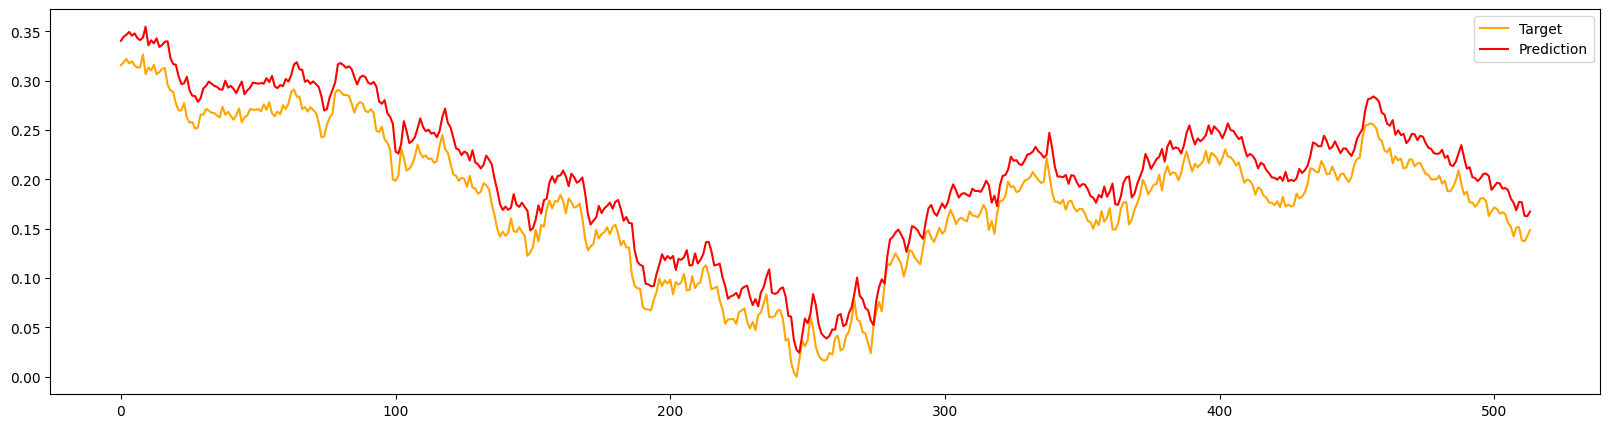

In [22]:
plot_target_predict(test_labels,predictions)

In [23]:
def plot(history):
  acc = history.history['mean_absolute_error']
  val_acc = history.history['val_mean_absolute_error']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

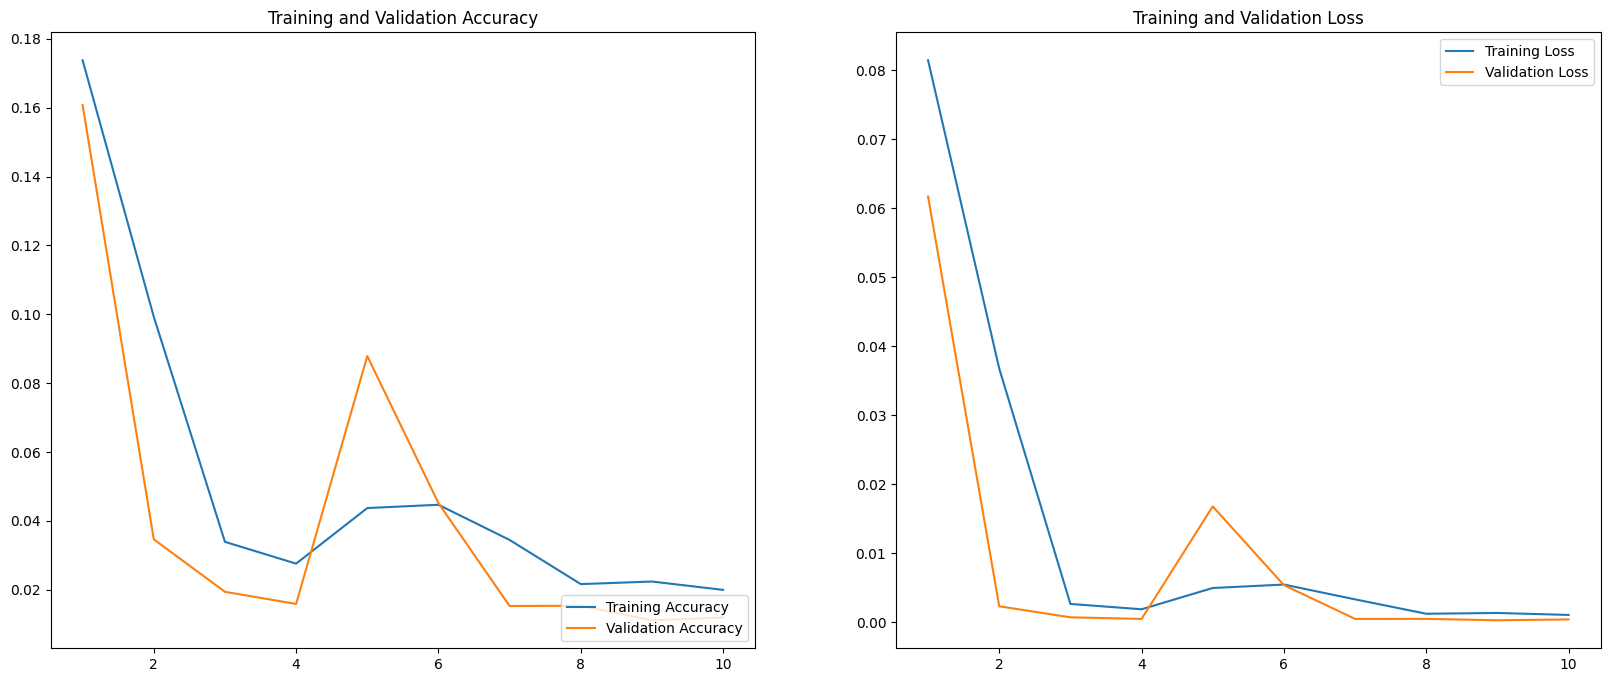

In [24]:
plot(history)

In [25]:
def calculate_profit(predictions,test_inputs):
  amount_of_profit = 0
  for i in range(1,len(predictions)):
    if (test_inputs[i,-1,3] > test_inputs[i-1,-1,3]):
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if(predictions[i,-1,3] > test_inputs[i-1,-1,3]):
          amount_of_profit += ((min(predictions[i,-1,3],test_inputs[i,-1,3])-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]) *10000
        else:
          amount_of_profit += -((test_inputs[i,-1,3] - test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3] * 10000)
    else:
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if (predictions[i,-1,3] <test_inputs[i-1,-1,3] ):
          amount_of_profit += (test_inputs[i-1,-1,3] - max(predictions[i,-1,3],test_inputs[i,-1,3]))/test_inputs[i-1,-1,3] * 10000
        else:
          amount_of_profit += (test_inputs[i,-1,3]-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]*1000
  return amount_of_profit

In [26]:
amount_of_profit = calculate_profit(predictions,test_inputs)

i zero...else...248


In [27]:
amount_of_profit

147811.93821367197

In [28]:
max_profit = calculate_profit(test_inputs,test_inputs)

i zero...else...248


In [29]:
max_profit

318537.04123241187

In [30]:

train_inputs,train_labels = get_input_Labels(multi_window.train)
len_recent_data = 10
i = 0
new_predictions = np.empty(shape = (0,n_steps,num_features))
print("len new pre..."+str(len(new_predictions)))
iteration = floor(len(test_inputs)/len_recent_data)
while i < iteration*len_recent_data :
    npredictions = feedback_model.predict(test_inputs[i:i+len_recent_data])
    new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
    combined_data = np.concatenate((train_inputs, test_inputs[i:i+len_recent_data]), axis=0)
    combined_data_labels = np.concatenate((train_labels, test_labels[i:i+len_recent_data]), axis=0)
    multi_window.train = multi_window.make_dataset(combined_data[:,-1,:],64)
    #feedback_model.compile(loss=tf.keras.losses.MeanSquaredError(),
     #           optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
      #          metrics=[tf.keras.metrics.MeanAbsoluteError()])

    #history = feedback_model.fit(combined_data,combined_data_labels, epochs=7,
     #                 validation_data=multi_window.val)
    i += len_recent_data
    print("itrration....."+str(i))
print("last i...."+str(i))

len new pre...0
1/1 [==============================] - 0s 221ms/step
itrration.....10
1/1 [==============================] - 0s 20ms/step
itrration.....20
1/1 [==============================] - 0s 20ms/step
itrration.....30
1/1 [==============================] - 0s 18ms/step
itrration.....40
1/1 [==============================] - 0s 18ms/step
itrration.....50
1/1 [==============================] - 0s 20ms/step
itrration.....60
1/1 [==============================] - 0s 20ms/step
itrration.....70
1/1 [==============================] - 0s 18ms/step
itrration.....80
1/1 [==============================] - 0s 17ms/step
itrration.....90
1/1 [==============================] - 0s 17ms/step
itrration.....100
1/1 [==============================] - 0s 23ms/step
itrration.....110
1/1 [==============================] - 0s 20ms/step
itrration.....120
1/1 [==============================] - 0s 18ms/step
itrration.....130
1/1 [==============================] - 0s 19ms/step
itrration.....140
1/1 [=======

In [31]:
#npredictions = feedback_model.predict(test_inputs[i:])
#new_predictions = np.concatenate((new_predictions, npredictions), axis=0)

In [32]:
#len(new_predictions)

In [33]:
#plot_target_predict(test_labels,new_predictions)

In [34]:
#amount_of_profit = calculate_profit(new_predictions ,test_inputs)

In [35]:
#amount_of_profit

In [39]:
df_stock = yf.download('EURUSD=X', start='2000-01-01', end='2023-10-09',interval="1wk")
df_stock_month = monthly_data = df_stock.resample('1M').last()

[*********************100%%**********************]  1 of 1 completed


In [40]:
weekly_data = normalize_data(df_stock)
monthly_data = normalize_data(df_stock_month)

Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.973186  0.001492  0.000000  0.918713   1.540808       0
2022-09-19  0.053402  0.000060  0.594936  0.000000   0.969086       0
2022-09-26  0.000000  0.000011  0.584932  0.018322   0.980488       0
2022-10-10  0.007243  0.000000  0.591291  0.005452   0.972479       0
Removed Rows:
            Open  High  Low  Close  Adj Close  Volume
Date                                                 
2022-09-30   0.0   0.0  0.0    0.0   0.980488       0


In [41]:
column_indices,train_df_week,val_df_week,test_df_week = spilitData(weekly_data)
column_indices_month,train_df_month,val_df_month,test_df_month = spilitData(monthly_data)

In [44]:
multi_window_week = WindowGenerator(input_width=n_steps,
                               label_width=1,
                               shift=1)
multi_window_week.train = multi_window_week.make_dataset(train_df_week,64)
multi_window_week.val = multi_window_week.make_dataset(val_df_week,64)
multi_window_week.test = multi_window_week.make_dataset(test_df_week,64)


multi_window_month = WindowGenerator(input_width=n_steps,
                               label_width=1,
                               shift=1)
multi_window_month.train = multi_window_month.make_dataset(train_df_month,64)
multi_window_month.val = multi_window_month.make_dataset(val_df_month,64)
multi_window_month.test = multi_window_month.make_dataset(test_df_month,64)

In [45]:
history = compile_and_fit(feedback_model, multi_window_week,100)

Epoch 1/50
65/65 [==============================] - 4s 19ms/step - loss: 0.0258 - mean_absolute_error: 0.0776 - val_loss: 0.0117 - val_mean_absolute_error: 0.0614
Epoch 2/50
65/65 [==============================] - 1s 15ms/step - loss: 0.0169 - mean_absolute_error: 0.0757 - val_loss: 0.0073 - val_mean_absolute_error: 0.0579
Epoch 3/50
65/65 [==============================] - 1s 15ms/step - loss: 0.0088 - mean_absolute_error: 0.0614 - val_loss: 0.0106 - val_mean_absolute_error: 0.0718
Epoch 4/50
65/65 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0374 - val_loss: 3.4595e-04 - val_mean_absolute_error: 0.0143
Epoch 5/50
65/65 [==============================] - 1s 14ms/step - loss: 8.9225e-04 - mean_absolute_error: 0.0188 - val_loss: 8.7696e-05 - val_mean_absolute_error: 0.0066
Epoch 6/50
65/65 [==============================] - 1s 14ms/step - loss: 7.4938e-04 - mean_absolute_error: 0.0167 - val_loss: 1.0320e-04 - val_mean_absolute_error: 0.0073
Ep

2/2 [==============================] - 0s 13ms/step


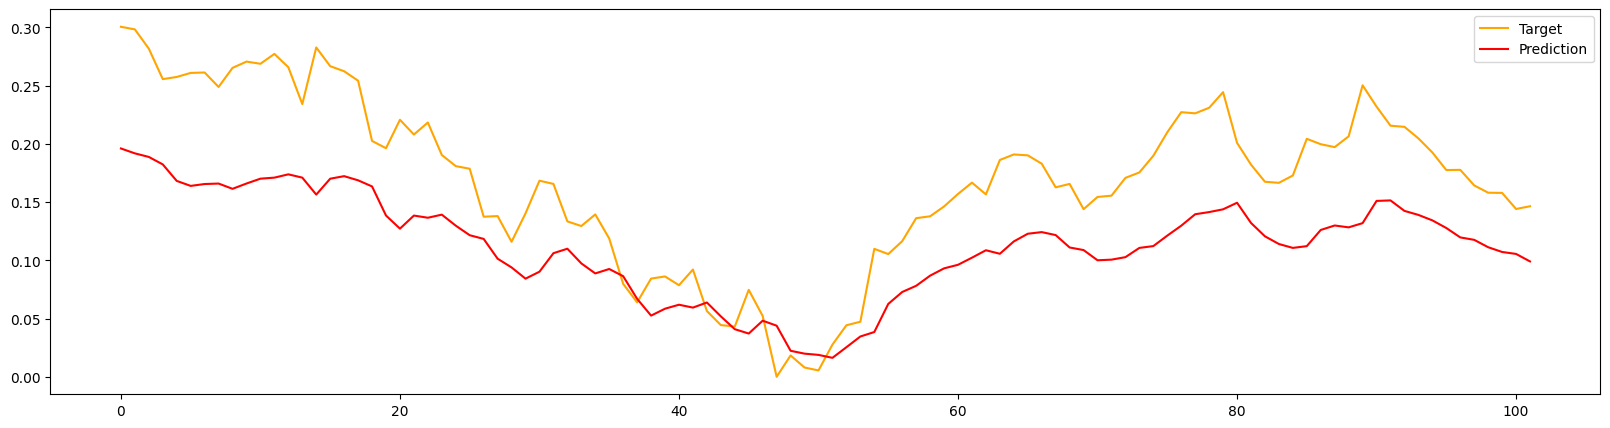

In [46]:
predictions_week = feedback_model.predict(multi_window_week.test)
test_inputs_week,test_labels_week = get_input_Labels(multi_window_week.test)
plot_target_predict(test_labels_week,predictions_week)

In [47]:
history = compile_and_fit(feedback_model, multi_window_month,50)

Epoch 1/50
65/65 [==============================] - 6s 25ms/step - loss: 0.0015 - mean_absolute_error: 0.0254 - val_loss: 4.2442e-04 - val_mean_absolute_error: 0.0147
Epoch 2/50
65/65 [==============================] - 1s 20ms/step - loss: 8.5484e-04 - mean_absolute_error: 0.0190 - val_loss: 7.6295e-04 - val_mean_absolute_error: 0.0212
Epoch 3/50
65/65 [==============================] - 1s 21ms/step - loss: 0.0018 - mean_absolute_error: 0.0272 - val_loss: 2.1567e-04 - val_mean_absolute_error: 0.0109
Epoch 4/50
65/65 [==============================] - 1s 21ms/step - loss: 8.8170e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 5/50
65/65 [==============================] - 1s 14ms/step - loss: 0.0022 - mean_absolute_error: 0.0306 - val_loss: 0.0024 - val_mean_absolute_error: 0.0322
Epoch 6/50
65/65 [==============================] - 1s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0288 - val_loss: 0.0013 - val_mean_absolute_error: 0.0257
Ep

1/1 [==============================] - 0s 244ms/step


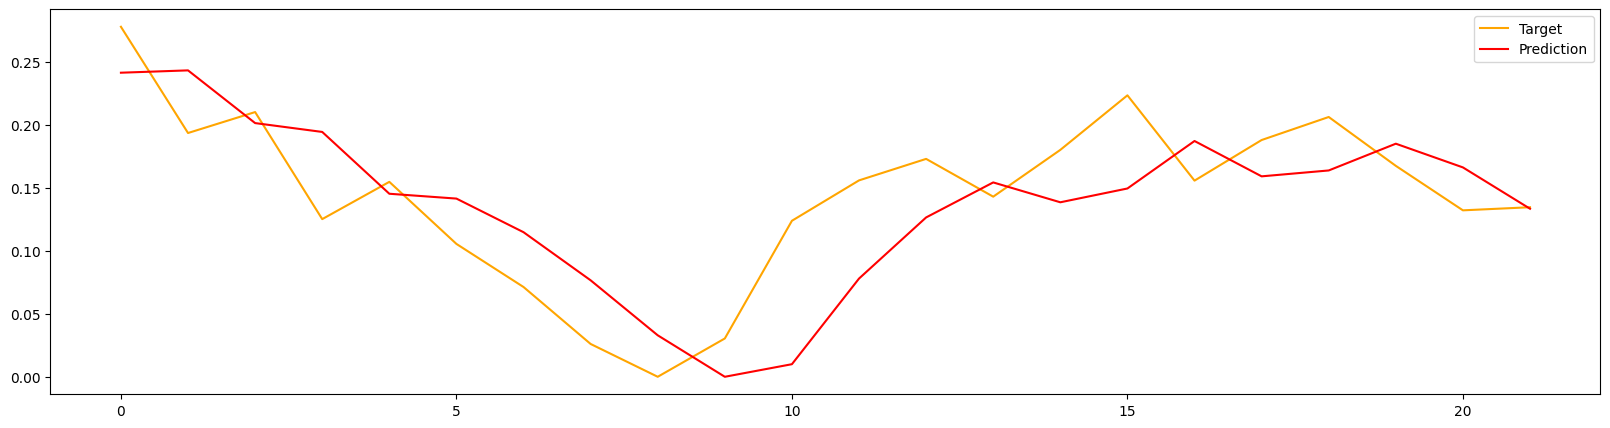

In [48]:
predictions_month = feedback_model.predict(multi_window_month.test)
test_inputs_month,test_labels_month = get_input_Labels(multi_window_month.test)
plot_target_predict(test_labels_month,predictions_month)

In [50]:
ensemble_predictions = (predictions_week. + predictions_month + predictions) / 3
dates = predictions.index
# Create a new DataFrame for ensemble predictions with the same date index
ensemble_df = pd.DataFrame(ensemble_predictions, index=dates, columns=["Ensemble Prediction"])

ValueError: ignored

In [ ]:
def future_data(start_date,num_days):
  data = {
      'Date': pd.to_datetime(['2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18']),
      'Open': [0] * 5,
      'High': [0] * 5,
      'Low': [0] * 5,
      'Close': [0] * 5,
      'Adj Close': [0] * 5,
      'Volume' : [0] * 5
  }
  df_next_days = pd.DataFrame(data)
  df_next_days = df_next_days.set_index('Date')
  return df_next_days

multi_window.test2 = multi_window.make_dataset(future_data())
predictions = feedback_model.predict(multi_window.test2)